# Probabilistic Multiple Cracking Model of Brittle-Matrix Composite: One-by-One Crack Tracing Algorithm



Annotated version of an algorithm implementation published in [citation and link will be added upon paper publication]

In [1]:
%matplotlib notebook
import numpy as np
from scipy.optimize import newton
import matplotlib.pylab as plt

In [2]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

## Crack bridge

This example uses the crack bridge model with a single fiber. 
Given a constant bond-slip law, the stress and strain distribution in the crack vicinity 
(a) has the profiles (b,c) 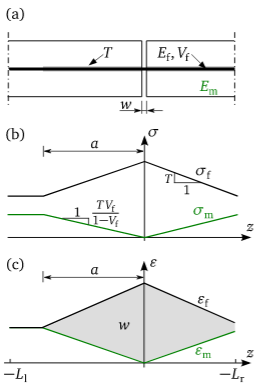

### Material parameters
| Symbol | Unit | Description
| :-: | :-: | :- |
| $E_\mathrm{m}$ | MPa | Elastic modulus of matrix |
| $E_\mathrm{f}$ | MPa | Elastic modulus of reinforcement |
| $V_\mathrm{f}$ |- | reinforcement ratio |
| $T$ | N/mm$^3$ | Bond intensity | 
| $\sigma_\mathrm{cu}$ | MPa | Composite strength |
| $\sigma_\mathrm{mu}$ | MPa | Scale parameter of matrix strength distribution |
| $m$ | - | Weibull modulus |
| $L$ | [mm] | Specimen length |
| $n_\mathrm{points}$ | - | Number of discretization points |

The following initial values of material parameters are defined to globally defined variables used in the algorithm. They can be modified and the notebook can be subsequently run from top again.

In [3]:
Em=25e3  # [MPa] matrix modulus
Ef=180e3  # [MPa] fiber modulus
vf=0.01  # reinforcement ratio
T=12.  # bond intensity
sig_cu=10.0 # [MPa] composite strength
sig_mu=3.0 # [MPa] matrix strength
m=10000 # Weibull shape modulus

### Calculation of matrix stress and fiber strain profiles

The one-by-one crack tracing algorithm requires a crack bridge model delivering two field variables centered at a crack bridge:

 - returning the matrix stress profile, and 
 - reinforcement strain profile.
 
Alternatively, instead of $\varepsilon_\mathrm{f}$, crack opening can be used to evaluate the nominal composite strain $\varepsilon_\mathrm{c}$ as described in the paper.

In [4]:
def get_sig_m(z, sig_c):  # matrix stress (*\label{sig_m}*)
    sig_m = np.minimum(z * T * vf / (1 - vf), Em * sig_c / (vf * Ef + (1 - vf) * Em))
    return sig_m

def get_eps_f(z, sig_c):  # reinforcement strain (*\label{sig_f}*)
    sig_m = get_sig_m(z, sig_c)
    eps_f = (sig_c - sig_m * (1 - vf)) / vf / Ef
    return eps_f

## Tensile test modeled as evolving chain of crack bridges

Subsidiary methods required to integrate the state fields along the tensile test specimen

### Update the distances $z$ of material points $x$ to a nearest cracks $x_K$

Distance of a global points $x$ from a nearest crack stored as a field variable $z(x)$.

In [5]:
def get_z_x(x, XK):  # distance to the closest crack (*\label{get_z_x}*)
    z_grid = np.abs(x[:, np.newaxis] - np.array(XK)[np.newaxis, :])
    return np.amin(z_grid, axis=1)

### Find the load factor needed to trigger a crack in all material points

For each point $x$, solve a non-linear equation delivering the crack-initiation load, accounting for arbitrary type of bond-slip law at the level of the crack-bridge model. 

In [6]:
import warnings # import exceptions
warnings.filterwarnings("error", category=RuntimeWarning) 
def get_sig_c_z(sig_mu, z, sig_c_pre): 
    # crack initiating load at a material element
    fun = lambda sig_c: sig_mu - get_sig_m(z, sig_c)
    try:  # search for the local crack load level
        return newton(fun, sig_c_pre)
    except (RuntimeWarning, RuntimeError):
        # solution not found (shielded zone) return the ultimate composite strength
        return sig_cu

### Identify the next crack position and corresponding composite stress

Find the smallest load factor along the specimen. Return the corresponding composite stress and the crack position $y$.

In [7]:
def get_sig_c_K(z_x, x, sig_c_pre, sig_mu_x):
    # crack initiating loads over the whole specimen
    get_sig_c_x = np.vectorize(get_sig_c_z)
    sig_c_x = get_sig_c_x(sig_mu_x, z_x, sig_c_pre) 
    y_idx = np.argmin(sig_c_x)
    return sig_c_x[y_idx], x[y_idx]

## Crack tracing algorithm

Define a function identifying the cracks one-by-one and recording the composite response.

In [8]:
n_x=5000
L_x=500
def get_cracking_history(update_progress=None):
    x = np.linspace(0, L_x, n_x)  # specimen discretization (*\label{discrete}*)
    sig_mu_x = sig_mu * np.random.weibull(m, size=n_x) # matrix strength (*\label{m_strength}*)

    Ec = Em * (1-vf) + Ef*vf # [MPa] mixture rule

    XK = [] # recording the crack postions
    sig_c_K = [0.] # recording the crack initating loads
    eps_c_K = [0.] # recording the composite strains
    CS = [L_x, L_x/2] # crack spacing
    sig_m_x_K = [np.zeros_like(x)] # stress profiles for crack states

    idx_0 = np.argmin(sig_mu_x)
    XK.append(x[idx_0])  # position of the first crack
    sig_c_0 = sig_mu_x[idx_0] * Ec / Em
    sig_c_K.append(sig_c_0)
    eps_c_K.append(sig_mu_x[idx_0] / Em)
    
    while True:
        z_x = get_z_x(x, XK) # distances to the nearest crack
        sig_m_x_K.append(get_sig_m(z_x, sig_c_K[-1])) # matrix stress
        sig_c_k, y_i = get_sig_c_K(z_x, x, sig_c_K[-1], sig_mu_x) # identify next crack
        if sig_c_k == sig_cu: # (*\label{no_crack}*)
            break
        if update_progress: # callback to user interface
            update_progress(sig_c_k)
        XK.append(y_i) # record crack position
        sig_c_K.append(sig_c_k) # corresponding composite stress
        eps_c_K.append( # composite strain - integrate the strain field
        np.trapz(get_eps_f(get_z_x(x, XK), sig_c_k), x) / np.amax(x)) # (*\label{imple_avg_strain}*)
        XK_arr = np.hstack([[0], np.sort(np.array(XK)), [L_x]])
        CS.append(np.average(XK_arr[1:]-XK_arr[:-1])) # crack spacing
    
    sig_c_K.append(sig_cu) # the ultimate state
    eps_c_K.append(np.trapz(get_eps_f(get_z_x(x, XK), sig_cu), x) / np.amax(x))
    CS.append(CS[-1])
    if update_progress:
        update_progress(sig_c_k)
    return np.array(sig_c_K), np.array(eps_c_K), sig_mu_x, x, np.array(CS), np.array(sig_m_x_K)

## Interactive application

To provide an interactive interface within the `jupyter` notebook, this code 
combines the packages `ipywidgets` with `matplotlib`. This code is specific
to the jupyter environment and has nothing to do with the actual algorithmic
structure. This code has purely infrastructural character and is kept here for completeness.

In [9]:
## Interactive application
import ipywidgets as ipw
n_steps = 20
margs_sliders = {
    name : ipw.FloatSlider(description=desc, value=val, 
                            min=minval, max=maxval, step=(maxval-minval) / n_steps,
                           continuous_update=False)
    for name, desc, val, minval, maxval in [
        ('Em', r'\(E_\mathrm{m}\)', 28000, 1000, 50000),
        ('Ef', r'\(E_\mathrm{f}\)', 180000, 1000, 250000),
        ('vf', r'\(V_\mathrm{f}\)', 0.01, 0.00001, 0.4),
        ('T', r'\(T\)', 8, 0.0001, 20),
        ('sig_cu', r'\(\sigma_\mathrm{cu}\)', 10, 3, 100),
        ('sig_mu', r'\(\sigma_\mathrm{mu}\)',5.0, 1, 10),
        ('m', r'\(m\)',4,0.8,100),
        ('L_x', r'\(L\)',500,200,2000)
    ]
}
margs_sliders['n_x'] = ipw.IntSlider(description='n_x', value=200,
                             min=20, max=1000, step=10)
crack_slider = ipw.IntSlider(description='crack', value=0, min=0, max=1, step=1)
progress = ipw.FloatProgress(min=0, max=1) # instantiate the bar

fig, (ax, ax_sig_x) = plt.subplots(1,2,figsize=(8,3),tight_layout=True)
ax_cs = ax.twinx()

def update_progress(sig):
    progress.value = sig

def init():
    for key, sl in margs_sliders.items():
        globals()[key] = sl.value
    sig_c_K, eps_c_K, sig_mu_x, x, CS, sig_m_x_K = get_cracking_history(update_progress) # (*\label{calc_curve}*)
    progress.max = margs_sliders['sig_cu'].value
    ax.plot(eps_c_K, sig_c_K, marker='o') # (*\label{show_curve1}*)
    ax_sig_x.plot(x, sig_mu_x, color='red')

current_sig_m_x_K = []
current_x = []
def reset_crack_slider(x, sig_m_x_K):
    global current_sig_m_x_K, current_x, sig_m_line, sig_eps_marker
    current_sig_m_x_K = sig_m_x_K
    current_x = x
    n_cracks = len(sig_m_x_K)
    crack_slider.max = n_cracks-1
    crack_slider.value = 0
    sig_m_line, = ax_sig_x.plot(x, sig_m_x_K[0])
    sig_eps_marker, = ax.plot([0],[0],color='magenta',marker='o')
    
def update_crack_slider(crack):
    global sig_m_line, sig_eps_marker
    global sig_c_K, eps_c_K
    if len(current_sig_m_x_K) > 0:
        sig_m_line.set_ydata(current_sig_m_x_K[crack])
    sig_eps_marker.set_data(eps_c_K[crack],sig_c_K[crack])
        
def update(**mparams):
    global sig_c_K, eps_c_K
    for key, val in mparams.items():
        globals()[key] = val
    ax.clear()
    ax_cs.clear()
    ax_sig_x.clear()
    sig_c_K, eps_c_K, sig_mu_x, x, CS, sig_m_x_K = get_cracking_history(update_progress) # (*\label{calc_curve}*)
    n_c = len(eps_c_K) - 2 # numer of cracks
    ax.plot(eps_c_K, sig_c_K, marker='o', label='%d cracks:' % n_c) # (*\label{show_curve1}*)
    ax.set_xlabel(r'$\varepsilon_\mathrm{c}$ [-]'); ax.set_ylabel(r'$\sigma_\mathrm{c}$ [MPa]')
    ax_sig_x.plot(x, sig_mu_x, color='orange')
    ax_sig_x.fill_between(x, sig_mu_x, 0, color='orange',alpha=0.1)
    ax_sig_x.set_xlabel(r'$x$ [mm]'); ax_sig_x.set_ylabel(r'$\sigma$ [MPa]')
    ax.legend()
    eps_c_KK = np.array([eps_c_K[:-1], eps_c_K[1:]]).T.flatten()
    CS_KK = np.array([CS[:-1],CS[:-1]]).T.flatten()
    ax_cs.plot(eps_c_KK, CS_KK, color='gray')
    ax_cs.fill_between(eps_c_KK, CS_KK, color='gray', alpha=0.2)
    ax_cs.set_ylabel(r'$\ell_\mathrm{cs}$ [mm]');
    reset_crack_slider(x, sig_m_x_K)

def slider_layout():
    layout = ipw.Layout(grid_template_columns='1fr 1fr')
    slider_list = tuple(margs_sliders.values())
    grid = ipw.GridBox(slider_list, layout=layout)
    hbox_pr = ipw.HBox([progress])
    hbox = ipw.HBox([crack_slider])
    box = ipw.VBox([hbox_pr, hbox, grid])
    display(box)
    
init()
slider_layout()
ipw.interactive_output(update_crack_slider, {'crack':crack_slider})
ipw.interactive_output(update, margs_sliders);

<IPython.core.display.Javascript object>